In [37]:
import copy

from matplotlib import pyplot as plt
import sys

sys.path.append('../..')
from model.amm.omnipool_router import OmnipoolRouter
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.stableswap_amm import simulate_swap as simulate_stableswap_swap
from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent


# Current Omnipool numbers

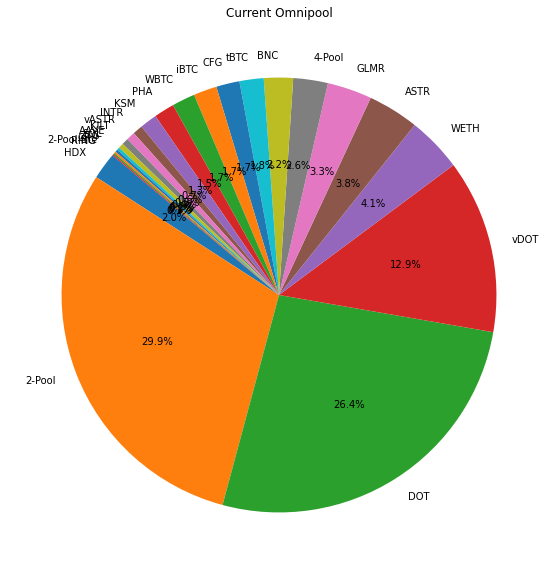

In [38]:
lrna_price = 25  # price of LRNA in USDT
current_omnipool_liquidity = {'HDX': 85_500_000, '2-Pool': 15_000_000,
                      'DOT': 2_717_000, 'vDOT': 905_800,
                      'WETH': 905.5, 'ASTR': 50_080_000,
                      'GLMR': 14_080_000, '4-Pool': 1_265_000,
                      'BNC': 5_972_000, 'tBTC': 10.79,
                      'CFG': 5_476_000, 'iBTC': 10.42,
                      'WBTC': 10.29, 'PHA': 5_105_000,
                      'KSM': 32_790, 'INTR': 67_330_000,
                      'vASTR': 7_165_000, 'KILT': 4_490_000,
                      'AAVE': 965.4, 'SOL': 754.4,
                      'ZTG': 8_229_000, 'CRU': 442_600,
                      '2-Pool-Btc': 0.6296, 'RING': 32_760_000}

usd_values = {'HDX': 1_000_000, '2-Pool': 15_000_000, 'DOT': 13_250_000,
              'vDOT': 6_475_000, 'WETH': 2_050_000, 'ASTR': 1_900_000,
              'GLMR': 1_660_000, '4-Pool': 1_290_000, 'BNC': 1_085_000,
              'tBTC': 900_000, 'CFG': 870_000, 'iBTC': 870_000,
              'WBTC': 860_000, 'PHA': 760_000, 'KSM': 640_000,
              'INTR': 370_000, 'vASTR': 320_000, 'KILT': 250_000,
              'AAVE': 190_000, 'SOL': 100_000, 'ZTG': 94_000,
              'CRU': 71_000, '2-Pool-Btc': 55_000, 'RING': 47_000}

lrna_amounts = {key: value / lrna_price for key, value in usd_values.items()}

tokens = {
    tkn: {'liquidity': current_omnipool_liquidity[tkn], 'LRNA': lrna_amounts[tkn]}
    for tkn in current_omnipool_liquidity
}

lrna_fee = DynamicFee(
    minimum=0.0005, maximum=0.0010, amplification=1,  # TODO get these numbers right
    decay=0.000001
)
asset_fee = DynamicFee(
    minimum=0.0025, maximum=0.01, amplification=2,  # TODO get these numbers right
    decay=0.00001
)
tokens_2_pool = {'USDT': 9_000_000, 'USDC': 8_000_000}
tokens_4_pool = {
    'USDT': 362000, 'USDC2': 262000,
    'DAI': 368000, 'USDT2': 323000
}

current_ss_2_pool = StableSwapPoolState(
    tokens=tokens_2_pool, amplification=100, trade_fee=0.0002, unique_id='2-Pool'  # TODO get these numbers right
)
current_ss_4_pool = StableSwapPoolState(
    tokens=tokens_4_pool, amplification=320, trade_fee=0.0002, unique_id='4-Pool'
)

# Extract labels and values
labels = list(lrna_amounts.keys())
sizes = list(lrna_amounts.values())

# Create pie chart
plt.figure(figsize=(10,10))  # Set figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Current Omnipool")
plt.show()


# Current pools

In [39]:
current_omnipool = OmnipoolState(
    tokens=tokens, lrna_fee=copy.deepcopy(lrna_fee), asset_fee=copy.deepcopy(asset_fee)
)
# current_exchanges = {'omnipool': current_omnipool, '2-Pool': current_ss_2_pool.copy(), '4-Pool': current_ss_4_pool.copy()}
current_exchanges = {'omnipool': current_omnipool, '2-Pool': current_ss_2_pool.copy()}
current_router = OmnipoolRouter(exchanges=current_exchanges)

# vDOT, DOT moved to gigaDOT pool

In [40]:
usd_value_vdot = usd_values['vDOT']
usd_value_dot = usd_values['DOT']
tokens_gigadot_pool = {
    'vDOT': current_omnipool_liquidity['vDOT'] * 2/3,
    'DOT': current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot * 2/3,
    'aDOT': current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot * 2/3,
}

omnipool_gigadot_tokens = {tkn: value for tkn, value in current_omnipool_liquidity.items()}
omnipool_gigadot_tokens['DOT'] -= current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot
del omnipool_gigadot_tokens['vDOT']

# scale LRNA by diff in tokens
gigadot_lrna_amounts = {tkn: omnipool_gigadot_tokens[tkn] / current_omnipool_liquidity[tkn] * lrna_amounts[tkn] for tkn in omnipool_gigadot_tokens}

tokens = {
    tkn: {'liquidity': omnipool_gigadot_tokens[tkn], 'LRNA': gigadot_lrna_amounts[tkn]}
    for tkn in omnipool_gigadot_tokens
}

gigadot_pool = StableSwapPoolState(
    tokens=tokens_gigadot_pool, amplification=100, trade_fee=0.0002, unique_id='gigaDOT'
)

omnipool_gigadot = OmnipoolState(
    tokens=tokens, lrna_fee=copy.deepcopy(lrna_fee), asset_fee=copy.deepcopy(asset_fee)
)

# exchanges_gigadot = {'omnipool': omnipool_gigadot, '2-Pool': current_ss_2_pool.copy(), '4-Pool': current_ss_4_pool.copy(), 'gigaDOT': gigadot_pool}
exchanges_gigadot = {'omnipool': omnipool_gigadot, '2-Pool': current_ss_2_pool.copy(), 'gigaDOT': gigadot_pool}
router_gigadot = OmnipoolRouter(exchanges=exchanges_gigadot)

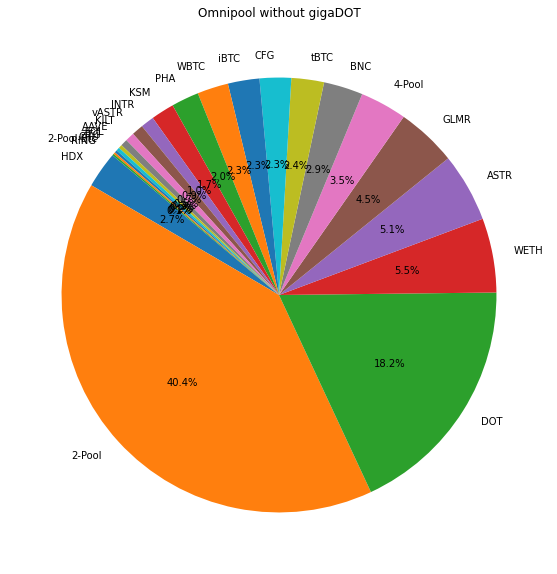

In [41]:
# Extract labels and values
labels = list(gigadot_lrna_amounts.keys())
sizes = list(gigadot_lrna_amounts.values())

# Create pie chart
plt.figure(figsize=(10,10))  # Set figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Omnipool without gigaDOT")
plt.show()

In [42]:
agent = Agent(enforce_holdings=False)
buy_sizes = [1, 10, 100, 1000, 10000]  # buying DOT with vDOT, DOT with USDT, vDOT with USDT
buy_sizes.sort()
# tkn_pairs = [('DOT', 'vDOT'), ('DOT', 'USDT'), ('vDOT', 'USDT')]
tkn_pairs = [('DOT', 'vDOT'), ('DOT', 'USDT')]
sell_amts_all = []
for router in [current_router, router_gigadot]:
    sell_amts = []
    for buy_size in buy_sizes:
        sell_amts_dict = {}
        for tkn_pair in tkn_pairs:
            new_state, new_agent = router.simulate_swap(
                agent, tkn_buy=tkn_pair[0], tkn_sell=tkn_pair[1], buy_quantity=buy_size
            )
            sell_amts_dict[tkn_pair] = -new_agent.get_holdings(tkn_pair[1])
        sell_amts.append(sell_amts_dict)
    sell_amts_all.append(sell_amts)



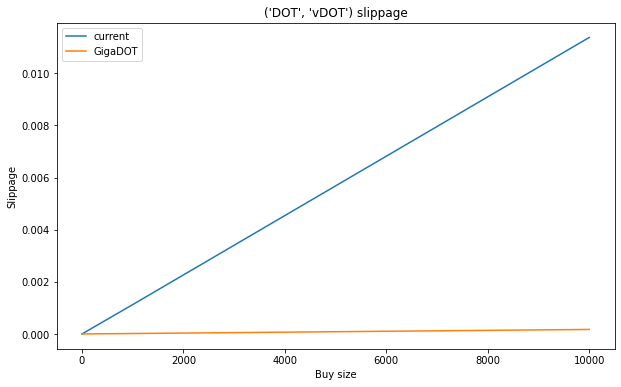

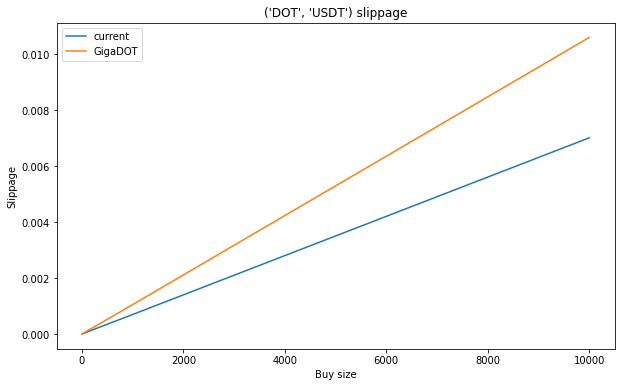

In [43]:
current_results, gigadot_results = sell_amts_all
current_slippage = {}
gigadot_slippage = {}
for tkn_pair in tkn_pairs:
    current_prices = [current_results[i][tkn_pair] / buy_sizes[i] for i in range(len(buy_sizes))]
    gigadot_prices = [gigadot_results[i][tkn_pair] / buy_sizes[i] for i in range(len(buy_sizes))]
    lowest_current_price = current_prices[0]
    lowest_gigadot_price = gigadot_prices[0]
    current_slippage[tkn_pair] = [(current_prices[i] - lowest_current_price) / lowest_current_price for i in range(len(buy_sizes))]
    gigadot_slippage[tkn_pair] = [(gigadot_prices[i] - lowest_gigadot_price) / lowest_gigadot_price for i in range(len(buy_sizes))]

for tkn_pair in tkn_pairs:
    plt.figure(figsize=(10,6))  # Set figure size
    plt.plot(buy_sizes, current_slippage[tkn_pair], label='current')
    plt.plot(buy_sizes, gigadot_slippage[tkn_pair], label='GigaDOT')
    plt.legend()
    plt.title(str(tkn_pair) + " slippage")
    plt.xlabel('Buy size')
    plt.ylabel('Slippage')
    plt.show()

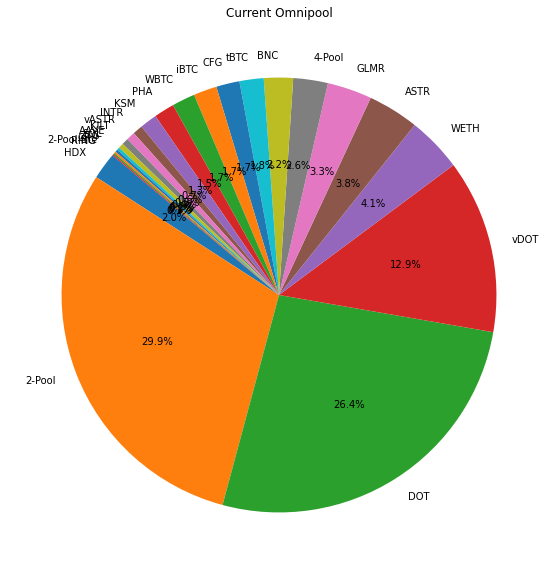

In [44]:
# Extract labels and values
labels = list(current_omnipool.lrna.keys())
sizes = list(current_omnipool.lrna.values())

# Create pie chart
plt.figure(figsize=(10,10))  # Set figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Current Omnipool")
plt.show()

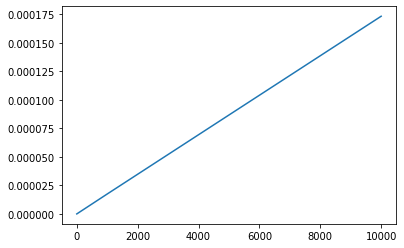

In [45]:
agent = Agent(enforce_holdings=False)
sell_amts = []
for buy_size in buy_sizes:
    new_state, new_agent = simulate_stableswap_swap(
        gigadot_pool, agent, tkn_buy='DOT', tkn_sell='vDOT', buy_quantity=buy_size
    )
    sell_amts.append(-new_agent.get_holdings('vDOT'))
prices = [sell_amts[i] / buy_sizes[i] for i in range(len(buy_sizes))]
lowest_price = prices[0]
slippage = [(prices[i]  - lowest_price) / lowest_price for i in range(len(buy_sizes))]

plt.plot(buy_sizes, slippage)